# Network Compression (Network Pruning)

In [ ]:
# Download dataset
!gdown --id '1wCdNcClcd2p5UeDi6XxNdiBedNaVn3fP' --output food-11.zip
# Unzip the files
!unzip food-11.zip

In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

!gdown --id '1lJS0ApIyi7eZ2b3GMyGxjPShI8jXM2UC' --output "hw7_Architecture_Design.ipynb"
%run "hw7_Architecture_Design.ipynb"

Downloading...
From: https://drive.google.com/uc?id=1lJS0ApIyi7eZ2b3GMyGxjPShI8jXM2UC
To: /content/hw7_Architecture_Design.ipynb
100% 8.78k/8.78k [00:00<00:00, 4.08MB/s]


In [ ]:
def network_slimming(old_model, new_model):
    params = old_model.state_dict()
    new_params = new_model.state_dict()
    
    # selected_idx: 每一層所選擇的neuron index
    selected_idx = []
    # 我們總共有7層CNN，因此逐一抓取選擇的neuron index們。
    old_parameters = [] # 觀察參數量總差異
    new_parameters = []
    for i in range(8):
        # 根據上表，我們要抓的gamma係數在cnn.{i}.1.weight內。
        importance = params[f'cnn.{i}.1.weight']
        # 抓取總共要篩選幾個neuron。
        old_dim = len(importance)
        new_dim = len(new_params[f'cnn.{i}.1.weight'])
        # 以Ranking做Index排序，較大的會在前面(descending=True)。
        ranking = torch.argsort(importance, descending=True)
        # 把篩選結果放入selected_idx中。
        selected_idx.append(ranking[:new_dim])
        old_parameters.append(old_dim)
        new_parameters.append(new_dim)

    now_processed = 1
    for (name, p1), (name2, p2) in zip(params.items(), new_params.items()):
        # 如果是cnn層，則移植參數。
        # 如果是FC層，或是該參數只有一個數字(例如batchnorm的tracenum等等資訊)，那麼就直接複製。
        if name.startswith('cnn') and p1.size() != torch.Size([]) and now_processed != len(selected_idx):
            # 當處理到Pointwise的weight時，讓now_processed+1，表示該層的移植已經完成。
            if name.startswith(f'cnn.{now_processed}.3'):
                now_processed += 1

            # 如果是pointwise，weight會被上一層的pruning和下一層的pruning所影響，因此需要特判。
            if name.endswith('3.weight'):
                # 如果是最後一層cnn，則輸出的neuron不需要prune掉。
                if len(selected_idx) == now_processed:
                    new_params[name] = p1[:,selected_idx[now_processed-1]]
                # 反之，就依照上層和下層所選擇的index進行移植。
                # 這裡需要注意的是Conv2d(x,y,1)的weight shape是(y,x,1,1)，順序是反的。
                else:
                    new_params[name] = p1[selected_idx[now_processed]][:,selected_idx[now_processed-1]]
            else:
                new_params[name] = p1[selected_idx[now_processed]]
        else:
            new_params[name] = p1

    # 讓新model load進被我們篩選過的parameters，並回傳new_model。        
    new_model.load_state_dict(new_params)
    print(old_parameters)
    print(new_parameters)
    return new_model


# Data Processing


In [ ]:
import re
import torch
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, folderName, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

        for img_path in glob(folderName + '/*.jpg'):
            try:
                # Get classIdx by parsing image path
                class_idx = int(re.findall(re.compile(r'\d+'), img_path)[1])
            except:
                # if inference mode (there's no answer), class_idx default 0
                class_idx = 0
 
            image = Image.open(img_path)
            # Get File Descriptor
            image_fp = image.fp
            image.load()
            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            self.data.append(image)
            self.label.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.label[idx]


trainTransform = transforms.Compose([
    transforms.RandomCrop(256, pad_if_needed=True, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
testTransform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

def get_dataloader(mode='training', batch_size=32):

    assert mode in ['training', 'testing', 'validation']

    dataset = MyDataset(
        f'./food-11/{mode}',
        transform=trainTransform if mode == 'training' else testTransform)

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'training'))

    return dataloader


# Pre-processing


In [ ]:
# get dataloader
train_dataloader = get_dataloader('training', batch_size=32)
valid_dataloader = get_dataloader('validation', batch_size=32)

In [ ]:
!gdown --id '12wtIa0WVRcpboQzhgRUJOpcXe23tgWUL' --output student_custom_small.bin

net = StudentNet().cuda() # 第二步載入的
net.load_state_dict(torch.load('student_custom_small.bin'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3)

Downloading...
From: https://drive.google.com/uc?id=12wtIa0WVRcpboQzhgRUJOpcXe23tgWUL
To: /content/student_custom_small.bin
100% 1.05M/1.05M [00:00<00:00, 69.8MB/s]


# Start Training




In [ ]:
def run_epoch(dataloader, update=True, alpha=0.5):
    total_num, total_hit, total_loss = 0, 0, 0
    for now_step, batch_data in enumerate(dataloader):
        # 清空 optimizer
        optimizer.zero_grad()
        # 處理 input
        inputs, labels = batch_data
        inputs = inputs.cuda()
        labels = labels.cuda()
  
        logits = net(inputs)
        loss = criterion(logits, labels)
        if update:
            loss.backward()
            optimizer.step()

        total_hit += torch.sum(torch.argmax(logits, dim=1) == labels).item()
        total_num += len(inputs)
        total_loss += loss.item() * len(inputs)

    return total_loss / total_num, total_hit / total_num
# width multiplier 控制通道縮減的比例
now_width_mult = 1
for i in range(5):
    now_width_mult *= 0.95
    new_net = StudentNet(width_mult=now_width_mult).cuda()
    params = net.state_dict()
    net = network_slimming(net, new_net)
    now_best_acc = 0
    for epoch in range(5):
        net.train()
        train_loss, train_acc = run_epoch(train_dataloader, update=True)
        net.eval()
        valid_loss, valid_acc = run_epoch(valid_dataloader, update=False)
        # 在每個width_mult的情況下，存下最好的model。
        if valid_acc > now_best_acc:
            now_best_acc = valid_acc
            torch.save(net.state_dict(), f'custom_small_rate_{now_width_mult}.bin')
        print('rate {:6.4f} epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(now_width_mult, 
            epoch, train_loss, train_acc, valid_loss, valid_acc))
        


# Line Graph

In [ ]:
!gdown --id '12wtIa0WVRcpboQzhgRUJOpcXe23tgWUL' --output student_custom_small.bin

net = StudentNet().cuda() # 第二步載入的
net.load_state_dict(torch.load('student_custom_small.bin'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3)

In [ ]:
now_width_mult = 1
for i in range(5):
    now_width_mult *= 0.95
    new_net = StudentNet(width_mult=now_width_mult).cuda()
    params = net.state_dict()
    net = network_slimming(net, new_net)
    now_best_acc = 0
    for epoch in range(1):
        net.train()
        train_loss, train_acc = run_epoch(train_dataloader, update=True)
        net.eval()
        valid_loss, valid_acc = run_epoch(valid_dataloader, update=False)
        # 在每個width_mult的情況下，存下最好的model。
        if valid_acc > now_best_acc:
            now_best_acc = valid_acc
            torch.save(net.state_dict(), f'custom_small_rate_{now_width_mult}.bin')
        print('rate {:6.4f} epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(now_width_mult, 
            epoch, train_loss, train_acc, valid_loss, valid_acc))

[16, 16, 32, 64, 128, 256, 256, 256]
[16, 16, 32, 64, 121, 243, 243, 243]
rate 0.9500 epoch   0: train loss: 0.4855, acc 0.8637 valid loss: 1.1046, acc 0.8026
[16, 16, 32, 64, 121, 243, 243, 243]
[16, 16, 32, 64, 115, 231, 231, 231]
rate 0.9025 epoch   0: train loss: 0.5963, acc 0.8434 valid loss: 1.2042, acc 0.7843
[16, 16, 32, 64, 115, 231, 231, 231]
[16, 16, 32, 64, 109, 219, 219, 219]
rate 0.8574 epoch   0: train loss: 0.6930, acc 0.8075 valid loss: 1.2040, acc 0.7679
[16, 16, 32, 64, 109, 219, 219, 219]
[16, 16, 32, 64, 104, 208, 208, 208]
rate 0.8145 epoch   0: train loss: 0.8415, acc 0.7744 valid loss: 1.2497, acc 0.7414
[16, 16, 32, 64, 104, 208, 208, 208]
[16, 16, 32, 64, 99, 198, 198, 198]
rate 0.7738 epoch   0: train loss: 1.0033, acc 0.7356 valid loss: 1.3896, acc 0.7099


In [ ]:
# Try a different purning rate
!gdown --id '12wtIa0WVRcpboQzhgRUJOpcXe23tgWUL' --output student_custom_small.bin

net = StudentNet().cuda() # 第二步載入的
net.load_state_dict(torch.load('student_custom_small.bin'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3)

Downloading...
From: https://drive.google.com/uc?id=12wtIa0WVRcpboQzhgRUJOpcXe23tgWUL
To: /content/student_custom_small.bin
100% 1.05M/1.05M [00:00<00:00, 69.2MB/s]


In [ ]:
now_width_mult = 1
for i in range(5):
    now_width_mult *= 0.9
    new_net = StudentNet(width_mult=now_width_mult).cuda()
    params = net.state_dict()
    net = network_slimming(net, new_net)
    now_best_acc = 0
    for epoch in range(1):
        net.train()
        train_loss, train_acc = run_epoch(train_dataloader, update=True)
        net.eval()
        valid_loss, valid_acc = run_epoch(valid_dataloader, update=False)
        # 在每個width_mult的情況下，存下最好的model。
        if valid_acc > now_best_acc:
            now_best_acc = valid_acc
            torch.save(net.state_dict(), f'custom_small_rate_{now_width_mult}.bin')
        print('rate {:6.4f} epoch {:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(now_width_mult, 
            epoch, train_loss, train_acc, valid_loss, valid_acc))

[16, 16, 32, 64, 128, 256, 256, 256]
[16, 16, 32, 64, 115, 230, 230, 230]
rate 0.9000 epoch   0: train loss: 0.6219, acc 0.8352 valid loss: 1.1966, acc 0.7761
[16, 16, 32, 64, 115, 230, 230, 230]
[16, 16, 32, 64, 103, 207, 207, 207]
rate 0.8100 epoch   0: train loss: 0.8342, acc 0.7716 valid loss: 1.2648, acc 0.7347
[16, 16, 32, 64, 103, 207, 207, 207]
[16, 16, 32, 64, 93, 186, 186, 186]
rate 0.7290 epoch   0: train loss: 1.1874, acc 0.6889 valid loss: 1.5461, acc 0.6776
[16, 16, 32, 64, 93, 186, 186, 186]
[16, 16, 32, 64, 83, 167, 167, 167]
rate 0.6561 epoch   0: train loss: 1.7141, acc 0.5790 valid loss: 1.9936, acc 0.5883
[16, 16, 32, 64, 83, 167, 167, 167]
[16, 16, 32, 64, 75, 151, 151, 151]
rate 0.5905 epoch   0: train loss: 2.1445, acc 0.4939 valid loss: 2.2865, acc 0.5152


In [ ]:
prune95 = [[16, 16, 32, 64, 128, 256, 256, 256], [16, 16, 32, 64, 121, 243, 243, 243], [16, 16, 32, 64, 115, 231, 231, 231], [16, 16, 32, 64, 109, 219, 219, 219], [16, 16, 32, 64, 104, 208, 208, 208], [16, 16, 32, 64, 99, 198, 198, 198]]
accuracy95 = [0.8026, 0.7843, 0.7679, 0.7414, 0.7099]
prune90 = [[16, 16, 32, 64, 128, 256, 256, 256], [16, 16, 32, 64, 115, 230, 230, 230], [16, 16, 32, 64, 103, 207, 207, 207], [16, 16, 32, 64, 93, 186, 186, 186], [16, 16, 32, 64, 83, 167, 167, 167], [16, 16, 32, 64, 75, 151, 151, 151]]
accuracy90 = [0.7761, 0.7347, 0.6776, 0.5883, 0.5152]
# 參數部分還需補上最後一層

In [ ]:
noneprune = 3*16*3**2 + 16*3**2 + 16*32 + 32*3**2 + 32*64 + 64*3**2 # 前面都一樣
parameters95 = []
p95 = noneprune
for j in range(len(prune95)):
  p95 = noneprune
  for i in range(4, 8):
      p95 += 64 * prune95[j][i] 
      p95 += prune95[j][i]*3**2
      if i != 7:
        p95 += prune95[j][i]*prune95[j][i+1]
  p95 += prune95[j][7] * 64 + 64 * 11
  parameters95.append(p95)

parameters90 = []
for j in range(len(prune90)):
  p90 = noneprune
  for i in range(4, 8):
      p90 += 64 * prune90[j][i] 
      p90 += prune90[j][i]*3**2
      if i != 7:
        p90 += prune90[j][i]*prune90[j][i+1]
  p90 += prune90[j][7] * 64 + 64 * 11
  parameters90.append(p90)

In [ ]:
print(parameters95[1:])
print(parameters90[1:])

[229807, 211759, 194431, 179320, 165975]
[210439, 177823, 150621, 127663, 109839]


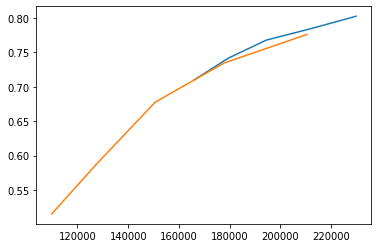

In [ ]:
import matplotlib.pyplot as plt

plt.plot(parameters95[1:], accuracy95)
plt.plot(parameters90[1:], accuracy90)
plt.show()